Implementation of 2D elasto-plastic problem using FEniCS-X. The code is based on a [legacy solution](https://comet-fenics.readthedocs.io/en/latest/demo/2D_plasticity/vonMises_plasticity.py.html) for FEniCS 2019.

The program was tested for 0.3.1.0 version of Dolfinx.

In [1]:
import meshio
import numpy as np
import numba

import ufl
from dolfinx import fem, io
from mpi4py import MPI
from petsc4py import PETSc
from dolfinx.geometry import (BoundingBoxTree, compute_colliding_cells, compute_collisions)
import time
import basix

import sys
sys.path.append("../assembling_strategies")
import custom_assembling as ca
# import fenicsx_support


In [2]:

def create_mesh(mesh, cell_type, prune_z=False):
    cells = mesh.get_cells_type(cell_type)
    cell_data = mesh.get_cell_data("gmsh:physical", cell_type)
    points = mesh.points[:,:2] if prune_z else mesh.points
    out_mesh = meshio.Mesh(points=points, cells={cell_type: cells}, cell_data={"name_to_read":[cell_data]})
    return out_mesh

# defining function to interpolate function defined over quadrature elements
def interpolate_quadrature(ufl_expr, fem_func):
    q_dim = fem_func.function_space._ufl_element.degree()
    mesh = fem_func.ufl_function_space().mesh
    
    basix_celltype = getattr(basix.CellType, mesh.topology.cell_type.name)
    quadrature_points, weights = basix.make_quadrature(basix_celltype, q_dim)
    map_c = mesh.topology.index_map(mesh.topology.dim)
    num_cells = map_c.size_local + map_c.num_ghosts
    cells = np.arange(0, num_cells, dtype=np.int32)

    expr_expr = fem.Expression(ufl_expr, quadrature_points)
    expr_eval = expr_expr.eval(cells)
    fem_func.x.array[:] = expr_eval.flatten()[:]
    fem_func.x.scatter_forward()

In [3]:
if MPI.COMM_WORLD.rank == 0:

    #It works with the msh4 only!!
    msh = meshio.read("thick_cylinder.msh")

    # Create and save one file for the mesh, and one file for the facets 
    triangle_mesh = create_mesh(msh, "triangle", prune_z=True)
    line_mesh = create_mesh(msh, "line", prune_z=True)
    meshio.write("thick_cylinder.xdmf", triangle_mesh)
    meshio.write("mt.xdmf", line_mesh)
    print(msh)
    


<meshio mesh object>
  Number of points: 811
  Number of cells:
    line: 10
    line: 69
    line: 10
    line: 53
    triangle: 1478
  Cell sets: gmsh:bounding_entities
  Point data: gmsh:dim_tags
  Cell data: gmsh:physical, gmsh:geometrical


In [4]:
with io.XDMFFile(MPI.COMM_WORLD, "thick_cylinder.xdmf", "r") as xdmf:
    mesh = xdmf.read_mesh(name="Grid")
    ct = xdmf.read_meshtags(mesh, name="Grid")

mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim - 1)

with io.XDMFFile(MPI.COMM_WORLD, "mt.xdmf", "r") as xdmf:
    ft = xdmf.read_meshtags(mesh, name="Grid")

In [5]:
# elastic parameters
E = 70e3
nu = 0.3
# lambda_ = E*nu/(1+nu)/(1-2*nu)
# mu_ = fem.Constant(mesh, PETSc.ScalarType(E/2./(1+nu)))

lambda_ = E*nu/(1+nu)/(1-2*nu)
mu_ = E/2./(1+nu)

# sig0 = fem.Constant(mesh, PETSc.ScalarType(250))  # yield strength
sig0 = 250.  # yield strength
Et = E/100.  # tangent modulus
H = E*Et/(E-Et)  # hardening modulus

Re, Ri = 1.3, 1.   # external/internal radius

# Hookes law for plane stress
# C11 = E / (1.0 - nu * nu)
# C12 = C11 * nu
# C33 = C11 * 0.5 * (1.0 - nu)
# C = np.array([[C11, C12, 0.0], [C12, C11, 0.0], [0.0, 0.0, C33]], dtype=PETSc.ScalarType)
# C_const = fem.Constant(mesh, C)


In [6]:
deg_u = 2
deg_stress = 2
V = fem.VectorFunctionSpace(mesh, ("CG", deg_u))
We = ufl.VectorElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, dim=4, quad_scheme='default')
W0e = ufl.FiniteElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, quad_scheme='default')
W = fem.FunctionSpace(mesh, We)
W0 = fem.FunctionSpace(mesh, W0e)

In [7]:
left_marker = 3
down_marker = 1
left_facets = ft.indices[ft.values == left_marker]
down_facets = ft.indices[ft.values == down_marker]
left_dofs = fem.locate_dofs_topological(V.sub(0), mesh.topology.dim-1, left_facets)
down_dofs = fem.locate_dofs_topological(V.sub(1), mesh.topology.dim-1, down_facets)

bcs = [fem.dirichletbc(PETSc.ScalarType(0), left_dofs, V.sub(0)), fem.dirichletbc(PETSc.ScalarType(0), down_dofs, V.sub(1))]

In [8]:
sig = fem.Function(W)
sig2 = fem.Function(W)
sig_old = fem.Function(W, name="sig_old")
n_elas = fem.Function(W)
beta = fem.Function(W0)
p = fem.Function(W0, name="p")
dp = fem.Function(W0, name="dp")
u = fem.Function(V, name="Total_displacement")
du = fem.Function(V, name="Iteration_correction")
Du = fem.Function(V, name="Current_increment")
Du_tmp = fem.Function(V, name="Du_tmp")
v = ufl.TrialFunction(V)
u_ = ufl.TestFunction(V)

P0 = fem.FunctionSpace(mesh, ("DG", 0))
p_avg = fem.Function(P0, name="Plastic_strain")

zero_Du = fem.Function(V)

In [9]:
# def identity_tensor(space_dim, tensor_dim):
#     I = np.zeros( (space_dim,) * tensor_dim )
#     I[ tuple([np.arange(space_dim)] * tensor_dim) ] = 1
#     return I

I = np.eye(3)
J4 = 1./3. * np.tensordot(I, I, axes=0)
I4 = np.einsum('ij,kl->ikjl', I, I)
K4 = DEV = I4 - J4
C_elas = (3*lambda_ + 2*mu_)*J4 + 2*mu_*K4
C_elas_const = fem.Constant(mesh, C_elas.astype(np.dtype(PETSc.ScalarType)))

QTe = ufl.TensorElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, shape=C_elas.shape, quad_scheme='default') #, symmetry=True?
QT = fem.FunctionSpace(mesh, QTe)
# C_tang_tmp = fem.Function(QT)

C_tang = ca.DummyFunction(QT, name='tangent') # 2 * n_gauss_points * 3 * 3 * 3 * 3

In [10]:
@numba.njit(fastmath=True)
def as_3D_array(X):
    return np.asarray([[X[0], X[3], 0],
                       [X[3], X[1], 0],
                       [0, 0, X[2]]])
                       
@numba.njit(fastmath=True)
def ppos(x):
    return (x + np.sqrt(x**2))/2.

@numba.njit(fastmath=True)
def sigma(eps_el):
    return lambda_*np.trace(eps_el)*I + 2*mu_*eps_el

@numba.njit(fastmath=True)
def tensor_product(A, B):
    # n_i, n_j = A.shape
    # n_k, n_l = B.shape
    C = np.zeros((*A.shape, *B.shape), dtype=PETSc.ScalarType)
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):
                    C[i,j,k,l] = A[i,j] * B[k,l]
    return C
                    
@numba.njit(fastmath=True)
def get_C_tang(beta, n_elas):
    return C_elas - 3*mu_*(3*mu_/(3*mu_+H)-beta)*tensor_product(n_elas, n_elas) - 2*mu_*beta*DEV 

@numba.njit(fastmath=True)
def inner(A, B):
    return np.sum(A * B)

def sigma_tang(e):
    N_elas = as_3D_tensor(n_elas)
    return sigma(e) - 3*mu_*(3*mu_/(3*mu_+H)-beta)*ufl.inner(N_elas, e)*N_elas - 2*mu_*beta*ufl.dev(e)  
    

In [11]:
unique_value = 17.
def get_eval():
    this_value = unique_value
    @numba.njit(fastmath=True)
    def eval():
        print(this_value + 1)
    
    return eval


In [12]:
ev = get_eval()

In [13]:
ev()

18.0


In [14]:
unique_value = 0.
ev()

18.0


In [15]:
# unique_value = 17.
# this_value = unique_value
# mylist = []
# mylist.append(np.array([1,2]))
# @numba.njit(fastmath=True)
# def eval(mylist):
#     a = mylist[0]
#     print(a)
# ev = eval
# ev(mylist)

In [16]:
def get_eval(self:ca.CustomFunction):
    tabulated_eps = self.tabulated_input_expression
    n_gauss_points = len(self.input_expression.X)
    # local_dim = self.local_dim # shape * n_gauss_points
    local_shape = self.local_shape
    
    # C_tang_size = np.prod(self.tangent.shape)
    C_tang_shape = self.tangent.shape
    # sig_old_global = self.global_values
    # p_old_global = self.p.x.array.reshape((-1, n_gauss_points, 1))
    
    @numba.njit(fastmath=True)
    def eval(sigma_current_local, sigma_old_local, p_old_local, coeffs_values, constants_values, coordinates, local_index, orientation):
        # sigma_local = sigma_old_local.reshape((n_gauss_points, *local_shape))
        deps_local = np.zeros(n_gauss_points*3*3, dtype=PETSc.ScalarType)
        
        # p_new_local = np.zeros((n_gauss_points, 1), dtype=PETSc.ScalarType)
        C_tang_local = np.zeros((n_gauss_points, *C_tang_shape), dtype=PETSc.ScalarType)
        
        # sigma_old_local = sig_old_global[cell].reshape((n_gauss_points, *local_shape))
        sigma_old = sigma_old_local.reshape((n_gauss_points, *local_shape))
        sigma_new = sigma_current_local.reshape((n_gauss_points, *local_shape))
        # p_old = p_old_local.reshape(p_old_local, (n_gauss_points, 1))

        # print(sigma_old_local, p_old_local)

        tabulated_eps(ca.ffi.from_buffer(deps_local), 
                      ca.ffi.from_buffer(coeffs_values), 
                      ca.ffi.from_buffer(constants_values), 
                      ca.ffi.from_buffer(coordinates), ca.ffi.from_buffer(local_index), ca.ffi.from_buffer(orientation))
        
        deps_local = deps_local.reshape((n_gauss_points, 3, 3))

        n_elas = np.zeros((3, 3), dtype=PETSc.ScalarType) 
        beta = np.zeros(1, dtype=PETSc.ScalarType) 

        # new_sig = np.zeros((3, 3), dtype=PETSc.ScalarType)

        # print(sig_old_global)
        for q in range(n_gauss_points):
            sig_n = as_3D_array(sigma_old[q])
            sig_elas = sig_n + sigma(deps_local[q])
            s = sig_elas - np.trace(sig_elas)*I/3.
            sig_eq = np.sqrt(3./2. * inner(s, s))
            f_elas = sig_eq - sig0 - H*p_old_local[q]
            dp = ppos(f_elas)/(3*mu_+H)

            if sig_eq != 0:
                n_elas[:,:] = s/sig_eq*ppos(f_elas)/f_elas 
                beta[:] = 3*mu_*dp/sig_eq                 
            
            new_sig = sig_elas - beta*s
            sigma_new[q][:] = np.array([new_sig[0, 0], new_sig[1, 1], new_sig[2, 2], new_sig[0, 1]])
            # p_old_local[q] += dp
            # # p_new_local[q][:] = p_old_global[cell][q] + dp
            
            C_tang_local[q][:] = get_C_tang(beta, n_elas)

        # sigma_old_local[:] = sigma_new.flatten()
        # print(sigma_old_local.flatten())
        
        return [C_tang_local.flatten()] # + , p_new_local.flatten() ?
    return eval

In [17]:
# @numba.njit(fastmath=True)
# def local_assembling(coeffs_values_global_b, coeffs_eval_b, coeffs_b, u_local, coeffs_constants_b, geometry, entity_local_index, perm):
#     sigma_old_local = coeffs_values_global_b[0][cell]
#     C_tang_local, p_new_local = coeffs_eval_b[0](cell, 
#                                      coeffs_b, 
#                                      u_local, 
#                                      coeffs_constants_b[0], 
#                                      geometry, entity_local_index, perm)
        
#         [:] = coeffs_b

#         for i in range(len(coeffs_dummy_values_b)):
#             coeffs_dummy_values_b[i][:] = output_values[i] #C_tang update

#         coeffs_A = coeffs_dummy_values_b[0]

#         for i in range(len(coeffs_coeff_values_b)):
#             coeffs_coeff_values_b[i][cell][:] = output_values[len(coeffs_dummy_values_b) + i]


In [18]:
n = ufl.FacetNormal(mesh)
q_lim = float(2/np.sqrt(3)*np.log(Re/Ri)*sig0)

loading = fem.Constant(mesh, PETSc.ScalarType(17.76))

def F_ext(v):
    return -loading * ufl.inner(n, v)*ds(4)

def eps(v):
    e = ufl.sym(ufl.grad(v))
    return ufl.as_tensor([[e[0, 0], e[0, 1], 0],
                          [e[0, 1], e[1, 1], 0],
                          [0, 0, 0]])

def as_3D_tensor(X):
    return ufl.as_tensor([[X[0], X[3], 0],
                          [X[3], X[1], 0],
                          [0, 0, X[2]]])

def inner_product(C, epsilon):
    i, j, k, l = ufl.indices(4)
    return ufl.as_tensor( (C[i,j,k,l] * epsilon[k,l]), (i,j) )

def my_sigma(eps_el):
    return lambda_*ufl.tr(eps_el)*ufl.Identity(3) + 2*mu_*eps_el


pppos = lambda x: (x + ufl.sqrt(x**2))/2.
def proj_sig(deps):
    # sig_n = as_3D_tensor(old_sig)
    sig_elas = my_sigma(deps)
    # s = ufl.dev(sig_elas)
    # sig_eq = ufl.sqrt(3/2.*ufl.inner(s, s))
    # f_elas = sig_eq - sig0 - H*old_p
    # dp = pppos(f_elas)/(3*mu_+H)
    # n_elas = s/sig_eq*pppos(f_elas)/f_elas
    # beta = 3*mu_*dp/sig_eq
    new_sig = sig_elas
    # -beta*s
    return ufl.as_vector([new_sig[0, 0], new_sig[1, 1], new_sig[2, 2], new_sig[0, 1]])
    # , \
    #        ufl.as_vector([n_elas[0, 0], n_elas[1, 1], n_elas[2, 2], n_elas[0, 1]]), \
    #        beta, dp         

# def sigma_tang(e):
#     N_elas = as_3D_tensor(n_elas)
#     return sigma(e) - 3*mu_*(3*mu_/(3*mu_+H)-beta)*ufl.inner(N_elas, e)*N_elas - 2*mu_*beta*ufl.dev(e)  



In [19]:
# QTe = ufl.TensorElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, shape=(C_elas.shape), quad_scheme='default')
# QT = fem.FunctionSpace(mesh, QTe)

# QTVoigte = ufl.TensorElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, shape=(6, 6), quad_scheme='default')
# QTVoigt = fem.FunctionSpace(mesh, QTe)

# C_tang_tmp = fem.Function(QT)
# C_tang_tmp_Voigt = fem.Function(QTVoigt)
# Voigt_map = np.array([[0, 5, 4], [5, 1, 3], [4, 3, 2]], dtype=np.uint8)
# def to_Voigt_ufl_tensor(A, A_Voigt):
#     assert A.shape == (3, 3, 3, 3)
#     for i in range(3):
#         for j in range(3):
#             for k in range(3):
#                 for l in range(3):
#                     alpha = Voigt_map[i,j] 
#                     beta = Voigt_map[k,l]
#                     A_Voigt[alpha, beta] = A[i,j,k,l]

In [20]:
sig = ca.CustomFunction(W, eps(Du), [C_tang, p, sig_old], get_eval)

In [21]:
ds = ufl.Measure("ds", domain=mesh, subdomain_data=ft)
dx = ufl.Measure(
    "dx",
    domain=mesh,
    metadata={"quadrature_degree": deg_stress, "quadrature_scheme": "default"},
)

a_Newton = ufl.inner(eps(v), inner_product(sig.tangent, eps(u_)))*dx
res = -ufl.inner(eps(u_), as_3D_tensor(sig))*dx 
res_Neumann = F_ext(u_)

# a_Newton = ufl.inner(eps(v), sigma_tang(eps(u_)))*dx
# res = -ufl.inner(eps(u_), as_3D_tensor(sig))*dx + F_ext(u_)

def project(original_field, target_field, bcs=[]):
    # original_field -> target_field
    # Ensure we have a mesh and attach to measure
    V = target_field.function_space

    # Define variational problem for projection
    w = ufl.TestFunction(V)
    Pv = ufl.TrialFunction(V)
    a = fem.form(ufl.inner(Pv, w) * dx)
    L = fem.form(ufl.inner(original_field, w) * dx)

    # Assemble linear system
    A = fem.petsc.assemble_matrix(a, bcs)
    A.assemble()
    b = fem.petsc.assemble_vector(L)
    fem.petsc.apply_lifting(b, [a], [bcs])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b, bcs)

    # Solve linear system
    solver = PETSc.KSP().create(A.getComm())
    solver.setOperators(A)
    solver.solve(b, target_field.vector)  
    target_field.x.scatter_forward()


In [22]:
# def sigma(eps_el):
#     return lambda_*ufl.tr(eps_el)*ufl.Identity(3) + 2*mu_*eps_el

# a_Newton = ufl.inner(eps(v), sigma(eps(u_)))*dx
# # a_Newton = ufl.inner(eps(v), inner_product(C_elas_const, eps(u_)))*dx

# # b = fem.petsc.create_vector(fem.form(res))
# A = fem.petsc.create_matrix(fem.form(a_Newton))
# A.zeroEntries()
# fem.petsc.assemble_matrix(A, fem.form(a_Newton), bcs=bcs)
# A.assemble()
# A.norm()

In [23]:
24426291.183643162
20379404.267960504

20379404.267960504

In [24]:
my_solver = ca.CustomSolver(a_Newton, res, Du, bcs)

In [25]:
# Defining a cell containing (Ri, 0) point, where we calculate a value of u

cells = []
points_on_proc = []
x_point = np.zeros((1, 3))
x_point[0][0] = Ri
tree = BoundingBoxTree(mesh, mesh.geometry.dim)
cell_candidates = compute_collisions(tree, x_point)
colliding_cells = compute_colliding_cells(mesh, cell_candidates, x_point)
for i, point in enumerate(x_point):
    if len(colliding_cells.links(i)) > 0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])

In [26]:
Nitermax, tol = 20, 1e-8  # parameters of the Newton-Raphson procedure
Nincr = 20
load_steps = np.linspace(0, 1.1, Nincr+1)[1:]**0.5
load_steps = load_steps

results = np.zeros((Nincr+1, 2))
# xdmf = io.XDMFFile(MPI.COMM_WORLD, "plasticity.xdmf", "w", encoding=io.XDMFFile.Encoding.HDF5)
# xdmf.write_mesh(mesh)

Res_Neumann = fem.petsc.create_vector(fem.form(res_Neumann))

start = time.time()

for (i, t) in enumerate(load_steps):
    loading.value = t * q_lim
    with Res_Neumann.localForm() as b_local:
        b_local.set(0.0)
    fem.petsc.assemble_vector(Res_Neumann, fem.form(res_Neumann))
    # print(t * q_lim, Res_Neumann.norm())
    # my_solver.data_extraction() ##!!!!!!
    # print(my_solver.constants_values_b)
    # Res0 = fem.petsc.assemble_vector(fem.form(res))
    # Res0.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    # fem.set_bc(Res0, bcs, du.vector)

    # nRes0 = Res0.norm() # Which one? - ufl.sqrt(Res.dot(Res))
    nRes0 = Res_Neumann.norm()
    nRes = nRes0
    nRes = 1
    # zero_Du.vector.copy(Du.vector)
    Du_tmp.vector.set(0.0)
    Du.vector.set(0.0)
    Du_tmp.x.scatter_forward()
    if MPI.COMM_WORLD.rank == 0:
        print(f"\nnRes0 , {nRes0} \n Increment: {str(i+1)}, load = {loading.value}")
    niter = 0
    # print('sig', sig.vector.norm(), np.max(sig.x.array), np.min(sig.x.array))
     
    while nRes > tol and niter < Nitermax:
        # print('Du', Du.vector.norm(), np.max(Du.x.array), np.min(Du.x.array))
        my_solver.solve(du, b_additional=Res_Neumann)
        du.x.scatter_forward() 
        print('sig', sig.vector.norm(), np.max(sig.x.array), np.min(sig.x.array))
        # for j in range(1478):
        #     print(sig.x.array.reshape((1478, -1))[j])
        # for j in range(1478):
        #     print(my_solver.coeffs_values_global_b[0][j])
        # print(du.vector.norm(), np.max(du.x.array), np.min(du.x.array))
        print(my_solver.A.norm(), my_solver.b.norm())

        Du_tmp.vector.axpy(1, du.vector) # Du = Du + 1*du
        Du_tmp.x.scatter_forward() 
        Du_tmp.vector.copy(Du.vector)

        deps = eps(Du_tmp)
        # sig_ = proj_sig(deps)

        # project(sig_, sig)
        # project(n_elas_, n_elas)
        # project(beta_, beta)
        # interpolate_quadrature(sig_, sig2)
        # interpolate_quadrature(n_elas_, n_elas)
        # interpolate_quadrature(beta_, beta)
        # sig.x.scatter_forward()
        # p.x.scatter_forward()

        # print('sig2', sig2.vector.norm(), np.max(sig2.x.array), np.min(sig2.x.array))

        # for j in range(1478):
        #     print(sig2.x.array.reshape((1478, -1))[j])

        # print(sig.vector.norm(), p.vector.norm())

        # Res = fem.petsc.assemble_vector(fem.form(res))
        # Res.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        # fem.set_bc(Res, bcs, du.vector)
        # print(sig.tangent.value.reshape((3, *C_elas.shape)) == C_elas)
        # print(np.max(np.abs(my_solver.b.array)))

        nRes = my_solver.b.norm() 
        if MPI.COMM_WORLD.rank == 0:
            print(f"    Residual: {nRes, nRes/nRes0}")
        niter += 1
    u.vector.axpy(1, Du.vector) # u = u + 1*Du
    u.x.scatter_forward()

    sig.sig_old.x.array[:] = sig.x.array
    # sig.vector.copy(sig_old.vector)
    # sig.x.scatter_forward()
    # print(sig.vector.norm(), np.max(sig.x.array), np.min(sig.x.array))

    # print(sig.vector.norm(), p.vector.norm())

    # project(dp_, dp)
    # interpolate_quadrature(dp_, dp)
    # p.vector.axpy(1, sig.dp.vector)
    p.x.scatter_forward()

    # print(np.max(p.x.array), np.min(p.x.array))
    project(p, p_avg)
    # interpolate_quadrature(p, p_avg)
    p_avg.x.scatter_forward()
    
    # xdmf.write_function(u, t)
    # xdmf.write_function(p_avg, t)

    if len(points_on_proc) > 0:
        results[i+1, :] = (u.eval(points_on_proc, cells)[0], t)

# xdmf.close()
end = time.time()
print(f'rank#{MPI.COMM_WORLD.rank}: Time = {end-start:.3f} (s)')
# 24426291.183643162


nRes0 , 2.853682976691151 
 Increment: 1, load = 17.7621446711497
sig 0.0 0.0 0.0
24426291.18364316 2.853682384400221
    Residual: (2.853682384400221, 0.9999997924468362)
sig 0.0 68.92404472194133 -43.195592830915594
24426291.18364316 4.765682153459638e-12
    Residual: (4.765682153459638e-12, 1.6700110672368563e-12)

nRes0 , 4.035717168349851 
 Increment: 2, load = 25.119465890772904
sig 0.0 68.92404472194133 -43.195592830915594
24426291.18364316 1.1820339463234755
    Residual: (1.1820339463234755, 0.29289315802246685)
sig 0.0 97.4733188193562 -61.08779321622851
24426291.18364316 1.9882371198588847e-12
    Residual: (1.9882371198588847e-12, 4.926601733767798e-13)

nRes0 , 4.942723904323467 
 Increment: 3, load = 30.764937021820067
sig 0.0 97.4733188193562 -61.08779321622851
24426291.18364316 0.9070065477213867
    Residual: (0.9070065477213867, 0.1835033809855363)
sig 0.0 119.37994732151927 -74.81696144620548
24426291.18364316 1.479133233507551e-12
    Residual: (1.479133233507551e

In [27]:
my_solver.b.array

array([ 0.00000000e+00, -4.02178291e-14, -3.48165941e-13, ...,
        2.79776202e-13, -1.87573915e-13,  4.54688370e-14])

In [28]:
p.x.array

array([0., 0., 0., ..., 0., 0., 0.])

In [29]:
sig.x.array

array([294.34460148,  -5.35636042, 140.30163536, ..., 296.08252323,
       141.99539661,  -4.57454409])

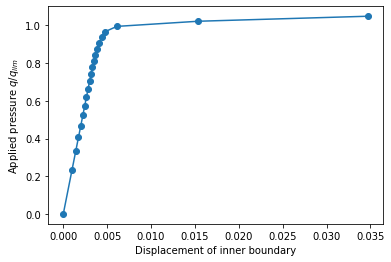

In [30]:
if len(points_on_proc) > 0:
    import matplotlib.pyplot as plt
    plt.plot(results[:, 0], results[:, 1], "-o")
    plt.xlabel("Displacement of inner boundary")
    plt.ylabel(r"Applied pressure $q/q_{lim}$")
    plt.savefig(f"displacement_rank{MPI.COMM_WORLD.rank:d}.png")
    plt.show()

In [31]:
u.x

In [32]:
u.vector

In [33]:
  # A.zeroEntries()
    # fem.petsc.assemble_matrix(A, fem.form(a_Newton), bcs=bcs)
    # A.assemble()

    # Res0 = fem.petsc.assemble_vector(fem.form(res))
    # with Res0.localForm() as loc_b:
    #     loc_b.set(0.)
    # fem.petsc.assemble_vector(Res0, fem.form(res))
    # Res0.assemble()

    # fem.petsc.apply_lifting(Res0, [fem.form(a_Newton)], [bcs], x0=[Du.vector], scale=-1.0)
    # Res0.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    # fem.petsc.set_bc(Res, bcs, Du.vector, -1.0)

    # solver.setOperators(A)

In [34]:
# Res.array.shape

In [35]:
du.vector.size

6198

In [36]:
du.x.array.size

6198

In [37]:
V.dofmap.

SyntaxError: invalid syntax (791267900.py, line 1)

In [ ]:
1478*2

2956

In [ ]:
V.dofmap.index_map.size_global

3099

In [ ]:
num_dofs_local = (V.dofmap.index_map.size_local) * V.dofmap.index_map_bs
num_dofs_global = V.dofmap.index_map.size_global * V.dofmap.index_map_bs

print(f"Number of dofs (owned) by rank : {num_dofs_local}")
# if COMM_WORLD.rank ==0:
print(f"Number of dofs global: {num_dofs_global}")

Number of dofs (owned) by rank : 6198
Number of dofs global: 6198
